In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3810860/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "MetaCartel - MetaCartel Ventures"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-01-06"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1088 non-null   object        
 1   author             1088 non-null   object        
 2   date               1088 non-null   datetime64[us]
 3   start              1088 non-null   datetime64[us]
 4   end                807 non-null    datetime64[us]
 5   platform_proposal  1088 non-null   object        
dtypes: datetime64[us](3), object(3)
memory usage: 51.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        3287 non-null   object        
 1   proposal  3287 non-null   object        
 2   voter     3287 non-null   object        
 3   date      3287 non-null   datetime64[us]
dtypes:

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/MetaCartel - MetaCartel Ventures/baseline/folds-info_W-THU_normalize.parquet
fold
2023-05-04    3242
2023-05-11    3242
2023-05-18    3242
2023-05-25    3245
2023-06-01    3246
2023-06-08    3253
2023-06-15    3262
2023-06-22    3275
2023-06-29    3285
2023-07-06    3285
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W18,1,9,9,9.00,1.00,0,0,0.00,nan
2023-W19,0,0,0,nan,nan,0,0,nan,nan
2023-W20,0,0,0,nan,nan,0,0,nan,nan
2023-W21,1,3,3,3.00,1.00,1,1,1.00,1.00
2023-W22,0,0,0,nan,nan,0,0,nan,nan
2023-W23,2,7,6,3.50,1.17,9,7,4.50,1.29
2023-W24,3,16,12,5.33,1.33,1,1,0.33,1.00
2023-W25,3,13,8,4.33,1.62,3,2,1.00,1.50
2023-W26,7,8,3,1.14,2.67,0,0,0.00,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W18 & 1 & 9 & 9 & 9.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W19 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W20 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W21 & 1 & 3 & 3 & 3.00 & 1.00 & 1 & 1 & 1.00 & 1.00 \\
2023-W22 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W23 & 2 & 7 & 6 & 3.50 & 1.17 & 9 & 7 & 4.50 & 1.29 \\
2023-W24 & 3 & 16 & 12 & 5.33 & 1.33 & 1 & 1 & 0.33 & 1.00 \\
2023-W25 & 3 & 13 & 8 & 4.33 & 1.62 & 3 & 2 & 1.00 & 1.50 \\
2023-W26 & 7 & 8 & 3 & 1.14 & 2.67 & 0 & 0 & 0.00 & nan \\
2023-W27 & 7 & 8 & 3 & 1.14 & 2.67 & 0 & 0 & 0.00 & nan \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/214 [00:00<?, ?it/s]

Warning, empty test fold 0 (2019-06-06 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2019-06-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2019-06-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2019-06-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2019-07-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2019-07-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2019-07-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2019-07-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 8 (2019-08-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 9 (2019-08-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 10 (2019-08-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2019-08-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 12 (2019-08-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 13 (2019-09-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 14 (2019-09-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 15 (2019-09-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 16 (2019-09-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 17 (2019-10-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 18 (2019-10-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 19 (2019-10-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 20 (2019-10-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 21 (2019-10-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 22 (2019-11-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 23 (2019-11-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 24 (2019-11-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 25 (2019-11-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 26 (2019-12-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 27 (2019-12-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 28 (2019-12-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 29 (2019-12-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 30 (2020-01-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 31 (2020-01-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 32 (2020-01-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 33 (2020-01-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 34 (2020-01-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 35 (2020-02-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 36 (2020-02-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 37 (2020-02-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 41 (2020-03-19 00:00:00), all ok since 4 folds ago


Warning, empty test fold 45 (2020-04-16 00:00:00), all ok since 4 folds ago
Warning, empty test fold 46 (2020-04-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 49 (2020-05-14 00:00:00), all ok since 3 folds ago


Warning, empty test fold 52 (2020-06-04 00:00:00), all ok since 3 folds ago


Warning, empty test fold 55 (2020-06-25 00:00:00), all ok since 3 folds ago


Warning, empty test fold 82 (2020-12-31 00:00:00), all ok since 27 folds ago
Warning, empty test fold 83 (2021-01-07 00:00:00), all ok since 1 folds ago


Warning, test fold 84 (2021-01-14 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 85 (2021-01-21 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 90 (2021-02-25 00:00:00), all ok since 7 folds ago


Warning, empty test fold 107 (2021-06-24 00:00:00), all ok since 17 folds ago


Warning, test fold 150 (2022-04-21 00:00:00) with less than 5 open proposals (3). all ok since 43 folds ago


Warning, test fold 155 (2022-05-26 00:00:00) with less than 5 open proposals (4). all ok since 5 folds ago


Warning, test fold 156 (2022-06-02 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 157 (2022-06-09 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 160 (2022-06-30 00:00:00) with less than 5 open proposals (3). all ok since 3 folds ago


Warning, test fold 163 (2022-07-21 00:00:00) with less than 5 open proposals (2). all ok since 3 folds ago


Warning, empty test fold 164 (2022-07-28 00:00:00), all ok since 57 folds ago
Warning, empty test fold 165 (2022-08-04 00:00:00), all ok since 1 folds ago


Warning, test fold 166 (2022-08-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 167 (2022-08-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 168 (2022-08-25 00:00:00), all ok since 3 folds ago


Warning, empty test fold 177 (2022-10-27 00:00:00), all ok since 9 folds ago


Warning, test fold 180 (2022-11-17 00:00:00) with less than 5 open proposals (4). all ok since 3 folds ago


Warning, empty test fold 181 (2022-11-24 00:00:00), all ok since 4 folds ago
Warning, test fold 182 (2022-12-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 183 (2022-12-08 00:00:00), all ok since 2 folds ago
Warning, test fold 184 (2022-12-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 185 (2022-12-22 00:00:00), all ok since 2 folds ago
Warning, empty test fold 186 (2022-12-29 00:00:00), all ok since 1 folds ago


Warning, test fold 187 (2023-01-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 188 (2023-01-12 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 189 (2023-01-19 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 190 (2023-01-26 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 191 (2023-02-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 192 (2023-02-09 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 193 (2023-02-16 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 194 (2023-02-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 195 (2023-03-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 199 (2023-03-30 00:00:00), all ok since 13 folds ago
Warning, test fold 200 (2023-04-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 201 (2023-04-13 00:00:00), all ok since 2 folds ago
Warning, empty test fold 202 (2023-04-20 00:00:00), all ok since 1 folds ago


Warning, test fold 203 (2023-04-27 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 204 (2023-05-04 00:00:00), all ok since 2 folds ago
Warning, empty test fold 205 (2023-05-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 206 (2023-05-18 00:00:00), all ok since 1 folds ago
Warning, test fold 207 (2023-05-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 208 (2023-06-01 00:00:00), all ok since 2 folds ago
Warning, test fold 209 (2023-06-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 210 (2023-06-15 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 211 (2023-06-22 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 212 (2023-06-29 00:00:00), all ok since 4 folds ago
Warning, empty test fold 213 (2023-07-06 00:00:00), all ok since 1 folds ago


Max ok in a row: (57, Timestamp('2022-07-28 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/MetaCartel - MetaCartel Ventures/baseline/openpop_W-THU_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,...,214.000000,214.000000,214.000000,214.000000,200.000000,188.000000,185.000000,185.000000,185.000000,214.000000
mean,0.159099,0.097236,0.073841,0.041870,0.028429,0.004481,0.154426,0.202775,0.226607,0.237017,...,0.330601,0.335734,0.348099,0.265652,0.316424,0.340515,0.348188,0.348188,0.348188,0.098694
std,0.296303,0.141329,0.093154,0.049814,0.033684,0.005257,0.286749,0.312629,0.312663,0.312146,...,0.396404,0.398661,0.404087,0.415428,0.420241,0.426356,0.426801,0.426801,0.426801,0.027661
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068054
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070403
50%,0.000000,0.000000,0.006897,0.014286,0.009524,0.001429,0.000000,0.000000,0.006865,0.048662,...,0.064583,0.064583,0.066964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106939
75%,0.163462,0.166667,0.150000,0.087500,0.059815,0.010000,0.163462,0.319744,0.392233,0.415087,...,0.720238,0.728571,0.750000,0.607639,0.723214,0.756944,0.777778,0.777778,0.777778,0.122820
max,1.000000,0.666667,0.400000,0.200000,0.133333,0.022500,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.289954


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/MetaCartel - MetaCartel Ventures/baseline/perfect_W-THU_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,...,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.696262,0.322244,0.207649,0.112483,0.077118,0.011769,0.696262,0.696262,0.696262,0.696262,...,0.693452,0.695485,0.696262,0.578569,0.674776,0.684964,0.693452,0.695485,0.696262,0.109888
std,0.460949,0.256407,0.191062,0.128888,0.096228,0.014955,0.460949,0.460949,0.460949,0.460949,...,0.459539,0.460475,0.460949,0.422178,0.456080,0.457485,0.459539,0.460475,0.460949,0.024480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071770
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074155
50%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.125320
75%,1.000000,0.463636,0.284286,0.142143,0.094762,0.014214,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127109
max,1.000000,1.000000,1.000000,1.000000,0.866667,0.130000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.132514


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,214,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,...,214.000000,214.000000,200.000000,188.000000,185.000000,185.000000,185.000000,214.000000,0.0,0.0
mean,2021-06-20 12:00:00,0.159099,0.097236,0.073841,0.041870,0.028429,0.004481,0.154426,0.202775,0.226607,...,0.348099,0.265652,0.316424,0.340515,0.348188,0.348188,0.348188,0.098694,NaN,NaN
min,2019-06-06 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068054,NaN,NaN
25%,2020-06-12 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070403,NaN,NaN
50%,2021-06-20 12:00:00,0.000000,0.000000,0.006897,0.014286,0.009524,0.001429,0.000000,0.000000,0.006865,...,0.066964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106939,NaN,NaN
75%,2022-06-28 06:00:00,0.163462,0.166667,0.150000,0.087500,0.059815,0.010000,0.163462,0.319744,0.392233,...,0.750000,0.607639,0.723214,0.756944,0.777778,0.777778,0.777778,0.122820,NaN,NaN
max,2023-07-06 00:00:00,1.000000,0.666667,0.400000,0.200000,0.133333,0.022500,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.289954,NaN,NaN
std,NaN,0.296303,0.141329,0.093154,0.049814,0.033684,0.005257,0.286749,0.312629,0.312663,...,0.404087,0.415428,0.420241,0.426356,0.426801,0.426801,0.426801,0.027661,NaN,NaN


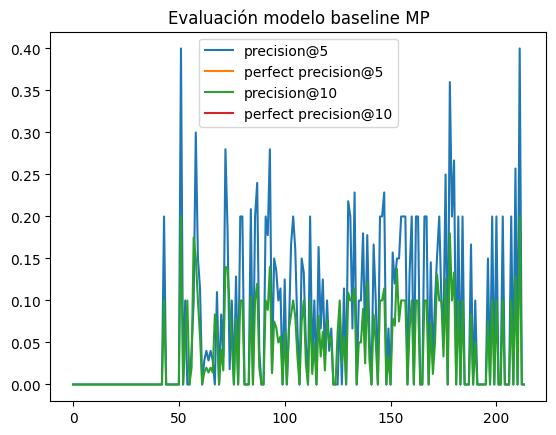

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-06-04 12:00:00,0.285714,0.142857,0.085714,0.042857,0.028571,0.004286,0.235714,0.244728,0.244728,...,0.300000,0.233333,0.300000,0.300000,0.300000,0.300000,0.300000,0.085921,NaN,NaN
min,2023-05-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068315,NaN,NaN
25%,2023-05-19 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069137,NaN,NaN
50%,2023-06-04 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070177,NaN,NaN
75%,2023-06-20 06:00:00,0.642857,0.250000,0.150000,0.075000,0.050000,0.007500,0.375000,0.375000,0.375000,...,0.750000,0.375000,0.750000,0.750000,0.750000,0.750000,0.750000,0.108196,NaN,NaN
max,2023-07-06 00:00:00,1.000000,0.666667,0.400000,0.200000,0.133333,0.020000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.123541,NaN,NaN
std,NaN,0.461684,0.243846,0.146308,0.073154,0.048769,0.007315,0.398481,0.414784,0.414784,...,0.483046,0.394405,0.483046,0.483046,0.483046,0.483046,0.483046,0.024421,NaN,NaN
